In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import dataloader as dal

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams.update(mpl.rcParamsDefault)

# https://zhuanlan.zhihu.com/p/480348215
# 一些默认配置，使得图表更美观
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
#plt.style.use('seaborn-whitegrid')
plt.style.use('ggplot')
#sns.set_style("white")
# 设置matplotlib正常显示中文
plt.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
plt.rcParams['axes.unicode_minus']=False 

In [3]:
tdt = pd.to_datetime

In [4]:
dl = dal.dataloader()
_=dl.get_slist()
dl.filter_slist(pd.to_datetime('2014-01-01'))
dl.get_sdata_tdx('E:/s/tdx/',start="2018/01/01",end='2021/01/31')

100%|██████████| 197/197 [00:03<00:00, 53.14it/s]


,,open,high,low,close,volume,amount
date,code,,,,,,
2018-01-02,000001,12.44,13.02,12.41,12.79,208159200.0,2.856543e+09
2018-01-03,000001,12.82,12.95,12.29,12.42,296249792.0,4.006220e+09
2018-01-04,000001,12.41,12.46,12.22,12.34,185450896.0,2.454543e+09
2018-01-05,000001,12.30,12.44,12.24,12.39,121031200.0,1.603289e+09
2018-01-08,000001,12.34,12.38,11.95,12.05,215862000.0,2.806099e+09
...,...,...,...,...,...,...,...
2021-01-25,300274,98.75,113.37,97.56,102.25,81047212.0,8.559588e+09
2021-01-26,300274,98.75,100.03,94.12,95.33,86710593.0,8.400924e+09
2021-01-27,300274,97.64,104.25,92.26,104.25,72114934.0,7.084138e+09


In [5]:
dl.add_factor(dal.alpha_6(dl.sdata),'factor1')
dl.add_factor(dal.momentum_nd(dl.sdata,3),'factor2')

In [6]:
temp=dl.sdata.iloc[:15,:]

In [7]:
dl.first_n_todict('factor1',5)
dl.first_n_todict('factor2',5)

In [8]:
dl.trade['factor2'][tdt('2019-09-10')]

Index(['000596', '600600', '600763', '600547', '601799'], dtype='object', name='code')

In [9]:
class PDcore():
    def __init__(self,slist,dlist,cash=100000):
        self.slist = slist
        self.dlist = dlist

        self.today = self.dlist.min()
        self.position = {}
        
        self.profit = pd.DataFrame(0,index=self.dlist,columns=self.slist)
        self.init_cash = cash
        self.cash = cash
        self.trade = {}
        self.balance = pd.DataFrame(0,index=self.dlist,columns=self.slist)
        self.balance['cash'] = 0
        self.risk = None
        
        self.x = 'open'
        
        for s in self.slist:
            self.trade[s]={}
        
    def _run(self,row,amount,verbose = True):
        s = row.code
        d = row.date
        # 记录每日结束现金余量
        if self.today<d:
            self.balance.loc[self.today,'cash'] = self.cash*1.
            self.today = d

        if amount > 0:
            self.buy(row,amount,verbose=verbose)
        elif amount < 0:
            self.sell(row,-amount,verbose=verbose)

    def buy(self,row,amount,verbose = True):
        s = row.code
        d = row.date
        price = getattr(row,self.x)
        if price*amount<=self.cash:
            if s in self.position:
                # 现金变动
                self.cash -= price*amount
                # 记录交易
                self.trade[s][d] = [price,amount]
                # 调整仓位
                value = (self.position[s][2]+price*amount)
                self.position[s] = [
                    value/(amount + self.position[s][1]),
                    amount + self.position[s][1],
                    value
                ]
                if verbose:
                    print('Date %s | Code %s | Amount %s | Add' % (d,s,amount))
            else:
                self.cash -= price*amount
                self.position[s] = [price, amount,price*amount]
                self.trade[s][d] = [price, amount]
                if verbose:
                    print('Date %s | Code %s | Amount %s | New' % (d,s,amount))
        else:
            print('Not enough money|',d)

    def sell(self,row,amount,verbose=True):
        s = row.code
        d = row.date
        price = getattr(row,self.x)
        # 是否有仓位
        if s in self.position:
            #是否有足够库存
            if self.position[s][1]>amount and (amount!=999):
                #现金变动
                self.cash += price*amount
                # 记录交易
                self.trade[s][d]= [price,-amount]
                # 调整仓位
                self.position[s] = [
                    self.position[s][0],
                    self.position[s][1]-amount,
                    self.position[s][2]-self.position[s][0]*amount
                ]
                # 计算利润
                self.profit.loc[d,s] = (price-self.position[s][0])*amount
                if verbose:
                    print('Date %s | Code %s | Amount %s | Sell' % (d,s,amount))
            else:
                # 清仓
                self.clear_position(row)
                if verbose:
                    print('Date %s | Code %s | Amount %s | Clear' % (d,s,amount))
                
    
    def clear_position(self, row):
        s = row.code
        d = row.date
        price = getattr(row,self.x)
        #现金变动
        self.cash += price*self.position[s][1]
        # 记录交易
        self.trade[s][d]= [price,-self.position[s][1]]
        # 计算利润
        self.profit.loc[d,s] = (price-self.position[s][0])*self.position[s][1]
        # 清仓
        del self.position[s]

    def end(self,d):
        # cash
        self.balance.loc[d,'cash'] = self.cash*1.
        # profit
        self.stock_profit = self.profit.sum()
        self.date_profit = self.profit.sum(axis=1)
        self.value = self.balance.sum(axis=1)
        self.drt=(self.value-self.value.shift(1).fillna(self.init_cash))/self.value
        _ = self.sharpe()

    def plot_value(self):
        self.value.plot()
        self.balance.cash.plot()
        plt.title('Value and cash')
        plt.ylim(bottom = 0)
        plt.show()

    def plot_rt(self):
        cumsum = self.drt.cumsum()
        sup = self.drt[0]
        drawback = []
        for i in cumsum:
            if i>=sup:
                sup = i
                drawback.append(0)
            else:
                drawback.append(sup-i)
        
        fig,ax=plt.subplots(3,1,sharex=True)
        ax[0].plot(cumsum)
        ax[0].set_ylabel('Cum return')
        ax[1].plot(self.balance.index,-np.array(drawback))
        ax[1].set_ylabel('Drawback')
        ax[2].scatter(self.drt.index,self.drt.values)
        ax[2].set_ylabel('Daily return')
        ax[2].set_xlabel('Date')
        fig.subplots_adjust(hspace=0.3)
        fig.suptitle(f'Snapshot\n Sharpe ratio:{self.sharpe_ratio}')
        plt.show()

    def date_balance(self,date:str):
        temp = self.balance.loc[pd.to_datetime(date)]
        return temp[temp!=0]

    def sharpe(self,rf=0,period=250):
        riskfree = 0
        if rf!=0:
            print('RF')
            riskfree = np.pow(1+rf,1/period)
        _drt = self.drt-riskfree
        self.sharpe_ratio =  _drt.mean()/_drt.std(ddof=1)*np.sqrt(period)
        return self.sharpe_ratio

    def add_risk(self,risk):
        risk.init(slist=self.slist,x=self.x)
        self.risk = risk

In [10]:
class PDcerebro(PDcore):
    def __init__(self,data,cash):
        self.data = data.dropna().reset_index().sort_values(by=['date','code'])
        # All stocks
        self.slist = self.data.code.unique()
        # All trading date
        self.dlist = self.data.date.unique()
        super().__init__(self.slist,self.dlist,cash)
        
        # The contaniner for strategies
        self.strategy = {}
        self.strat_position = {}

    def run(self,verbose = True):
        if self.strategy:
            # 有策略才运行
            for row in self.data.itertuples():
                s = row.code
                d = row.date
                price = getattr(row,self.x)
                if self.risk:
                    # 风控模块
                    amount = self.risk.run(row,self.position)
                    if amount <0:
                        print('risk control',d)         
                        for name , strat in self.strategy.items():
                            _ = strat.execute(row,self.strat_position[name])
                            self.adjust_strat_position(row,self.strat_position[name],amount)
                            self._run(row,amount,verbose=verbose)
                        self.risk.execute(s,d,price,amount,self.profit.loc[d,s])
                    else:
                        # 如风控无下单，正常交易            
                        for name , strat in self.strategy.items():
                            amount = strat.execute(row,self.strat_position[name])
                            self.adjust_strat_position(row,self.strat_position[name],amount)
                            self._run(row,amount,verbose=verbose)                        
                else:
                    # 如风控无下单，正常交易            
                    for name , strat in self.strategy.items():
                        amount = strat.execute(row,self.strat_position[name])
                        self.adjust_strat_position(row,self.strat_position[name],amount)
                        self._run(row,amount,verbose=verbose)

                # 记录仓位价值
                if s in self.position:
                    self.balance.loc[d,s] = row.open*self.position[s][1]
                    

             # 最后一天总结
            self.end(d)
            for _ , strat in self.strategy.items():
                strat.end(d)
                
        else:
            print('No strategy')

    def add_strats(self,strats,name = None):
        strats.init(self.slist,self.dlist,self.cash)

        if name:
            pass
        elif self.strategy:
            name = len(self.strategy)
        else:
            name = 0
            
        self.strategy[name] = strats
    
        self.strat_position[name] = {}

    def adjust_strat_position(self,row,position,amount):
        # control the position of strategies in the cerebro
        s = row.code
        d = row.date
        if s in position:
            if position[s] + amount <=0:
                del position[s]
            else:
                position[s]+= amount
        else:
            if amount >0:
                position[s] = amount

    def date_data(self,code,date):
        # 代码日期截取股票数据
        return self.data[(self.data.date==pd.to_datetime(date))&(self.data.code == code)]

In [11]:
class PDstrategy(PDcore):
    def __init__(self,verbose = True):
        self.active = True
        self.verbose =verbose

    def init(self, slist, dlist, cash=100000):
        super().__init__(slist, dlist, cash)
        self.active = True

    def cal(self,row):
        pass
    
    def execute(self,row,position):
        s = row.code
        d = row.date
        if self.active:
            # Strategy run
            _amount = self.cal(row,self.position)
            self._run(row,_amount,self.verbose)
            # Record balance at the end of the day
            if s in self.position:
                self.balance.loc[d,s] = row.open*self.position[s][1]
                
        # Cerebro amount
        return self.cal(row,position)
        

In [12]:
class Alpha6(PDstrategy):
    def __init__(self,date_trade):
        super().__init__()
        # date-trade dict
        self.date_trade = date_trade
        
    def cal(self,row,position):
        s = row.code
        d = row.date
        if s in position:
            if s in self.date_trade[d]:
                return 0
            else:
                return -100
        else:
            if s in self.date_trade[d]:
                return 100
            else:
                return 0


In [13]:
class Momentum_3d(PDstrategy):
    def __init__(self,date_trade):
        super().__init__()
        self.date_trade = date_trade
    def cal(self,row,position):
        s = row.code
        d = row.date
        if s in position:
            if s in self.date_trade[d]:
                return 0
            else:
                return -100
        else:
            if s in self.date_trade[d]:
                return 100
            else:
                return 0

In [14]:
class PDrisk():
    def __init__(self):
        self.record = {}
        self.blacklist = {}

        self.max = {}
        self.day = {}
        
    def init(self,slist,x):
        for s in slist:
            self.record[s] = {}
        self.x = x

    def run(self,row, position):
        # keep track of indicators
        s = row.code
        d = row.date
        price = getattr(row,self.x)
        
        # 风控黑名单（持续n天）
        if s in self.blacklist:
            self.blacklist[s] -= 1
            if self.blacklist[s]<0:
                del self.blacklist[s]
            else:
                return -999

        if s in position:
            if s in self.day:
                self.max[s] = max(self.max[s],price)
                self.day[s] += 1
            else:
                self.max[s] = max(position[s][0],price)
                self.day[s] = 1
            amount = self.cal(row,position)
            return amount
        else:
            if s in self.day:
                del self.max[s]
                del self.day[s]
            return 0

    def cal(self,row,position):
        # Risk control strategy
        return 0

    def execute(self,s,d,price,amount,profit):
        self.record[s][d] = [price,amount,profit]

In [15]:
class Cut(PDrisk):
    def __init__(self,percent=0.10,n=10):
        super().__init__()
        self.percent = percent
        self.n = n
    def cal(self,row,position):
        s = row.code
        d = row.date
        price = getattr(row,self.x)
        if (self.max[s]-price)/self.max[s] >self.percent:
            self.blacklist[s] = self.n
            return -position[s][1]
        else:
            return 0

# Try

In [16]:
temp

,,open,high,low,close,volume,amount,factor1,factor2
date,code,,,,,,,,
2018-01-02,000001,12.44,13.02,12.41,12.79,208159200.0,2.856543e+09,NaN,NaN
2018-01-03,000001,12.82,12.95,12.29,12.42,296249792.0,4.006220e+09,NaN,NaN
2018-01-04,000001,12.41,12.46,12.22,12.34,185450896.0,2.454543e+09,NaN,NaN
2018-01-05,000001,12.30,12.44,12.24,12.39,121031200.0,1.603289e+09,NaN,NaN
2018-01-08,000001,12.34,12.38,11.95,12.05,215862000.0,2.806099e+09,NaN,-0.40
2018-01-09,000001,12.05,12.29,12.01,12.17,134434496.0,1.754315e+09,NaN,-0.37
2018-01-10,000001,12.13,12.58,12.01,12.56,240327696.0,3.196055e+09,NaN,-0.17
2018-01-11,000001,12.50,12.68,12.36,12.49,144387696.0,1.937494e+09,NaN,0.17
2018-01-12,000001,12.54,12.77,12.50,12.64,135399104.0,1.833435e+09,NaN,0.44


In [17]:
a = {pd.to_datetime('2018-01-16'): ['601998', '600029', '601009', '601318'],
    pd.to_datetime('2018-01-17'): ['000001', '601288', '601009', '000800'], 
    pd.to_datetime('2018-01-18'): ['000001', '601939', '601288', '002459'],
    pd.to_datetime('2018-01-19'): ['002459', '601939', '601398', '601288'],
    pd.to_datetime('2018-01-22'): ['601939', '600111', '601328', '600015']}
b = {pd.to_datetime('2018-01-16'): ['000858', '600519', '002304', '002460'],
    pd.to_datetime('2018-01-17'): ['601998', '600029', '601009', '601318'], 
    pd.to_datetime('2018-01-18'): ['000001', '601939', '601288', '002459'],
    pd.to_datetime('2018-01-19'): ['000858', '600519', '002304', '002460'],
    pd.to_datetime('2018-01-22'): ['601939', '600111', '601328', '600015']}

In [18]:
core = PDcerebro(temp,100000)
core.data

,date,code,open,high,low,close,volume,amount,factor1,factor2
0,2018-01-16,000001,13.26,13.47,13.11,13.29,244454896.0,3.479176e+09,-0.489628,0.73
1,2018-01-17,000001,13.42,13.89,13.29,13.32,265629408.0,3.849312e+09,-0.466992,0.80
2,2018-01-18,000001,13.49,13.81,13.37,13.81,214802592.0,3.120455e+09,-0.497112,0.68
3,2018-01-19,000001,13.89,14.22,13.77,13.89,257114592.0,3.832857e+09,-0.447277,0.52
4,2018-01-22,000001,13.69,14.03,13.52,13.53,207386704.0,3.032798e+09,-0.446908,0.60


In [19]:
core.add_strats(Alpha6(a))
core.add_strats(Momentum_3d(a))
core.add_risk(Cut())

In [20]:
core.strategy[0].verbose = False
core.strategy[1].verbose = False

In [21]:
core.risk.record

{'000001': {}}

In [22]:
core.run(verbose=True)

Date 2018-01-17 00:00:00 | Code 000001 | Amount 100 | New
Date 2018-01-17 00:00:00 | Code 000001 | Amount 100 | Add
Date 2018-01-19 00:00:00 | Code 000001 | Amount 100 | Sell
Date 2018-01-19 00:00:00 | Code 000001 | Amount 100 | Clear


In [23]:
value=core.balance.sum(axis=1)

In [24]:
core.trade

{'000001': {Timestamp('2018-01-17 00:00:00'): [13.42, 100],
  Timestamp('2018-01-19 00:00:00'): [13.89, -100]}}

In [25]:
core.strategy[0].balance

,000001,cash
2018-01-16,0,100000
2018-01-17,1342,98658
2018-01-18,1349,98658
2018-01-19,0,100047
2018-01-22,0,100047


In [26]:
core.strategy[1].balance

,000001,cash
2018-01-16,0,100000
2018-01-17,1342,98658
2018-01-18,1349,98658
2018-01-19,0,100047
2018-01-22,0,100047


In [27]:
core.balance

,000001,cash
2018-01-16,0,100000
2018-01-17,2684,97316
2018-01-18,2698,97316
2018-01-19,0,100094
2018-01-22,0,100094


In [28]:
core.drt.values

array([0.        , 0.        , 0.00013998, 0.00079925, 0.        ])

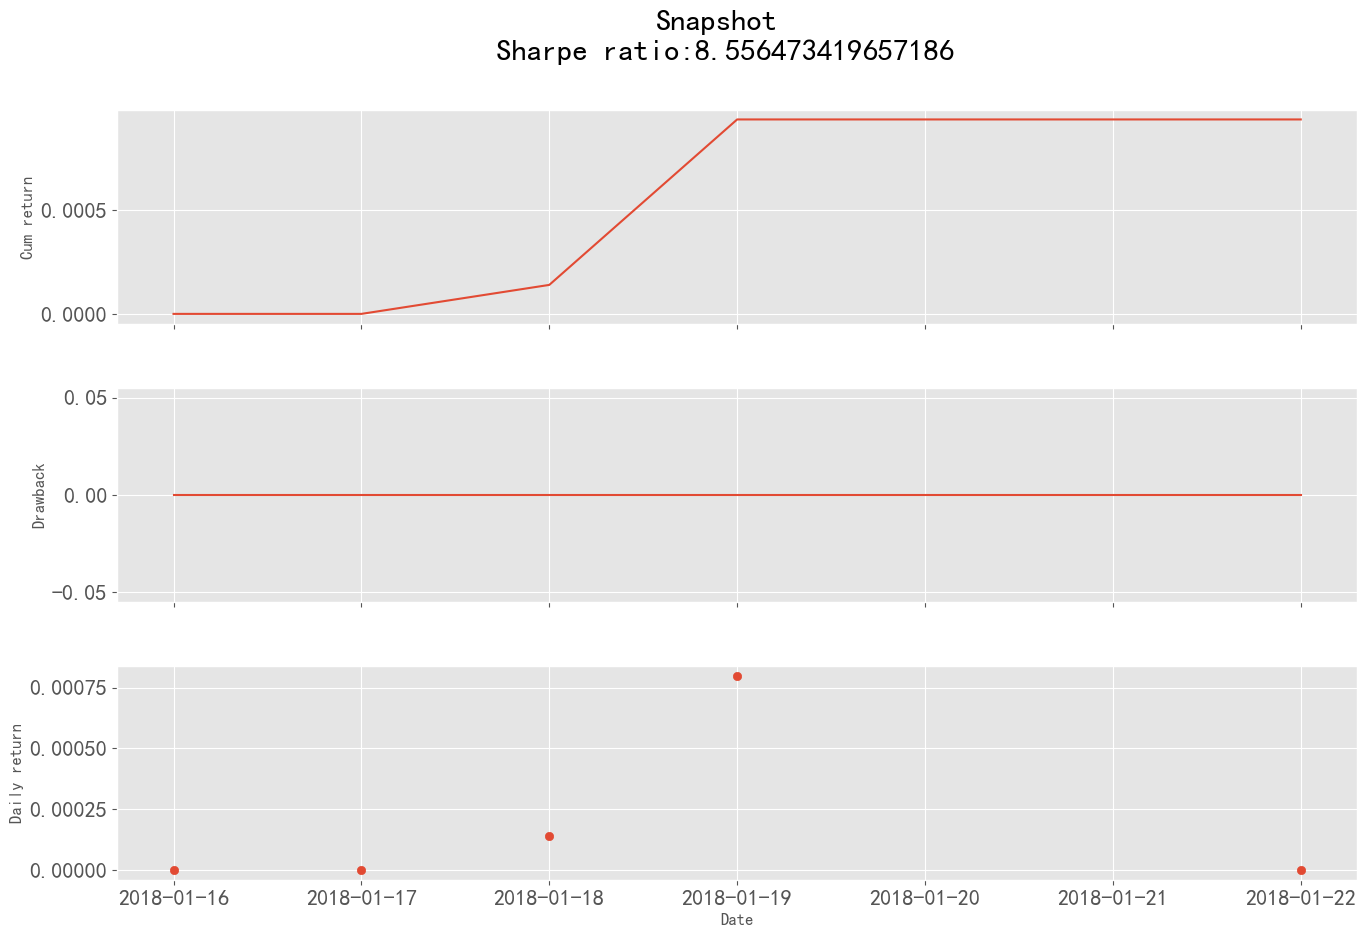

In [29]:
core.plot_rt()

In [30]:
core.risk.record

{'000001': {}}

# Formal

In [31]:
core = PDcerebro(dl.sdata.reset_index(level=1)[dl.sdata.reset_index(level=1).code=='600519'],100000)

In [32]:
core = PDcerebro(dl.sdata,100000)

In [33]:
core.add_strats(Alpha6(dl.trade['factor1']))
core.add_strats(Alpha6(dl.trade['factor2']))
#core.add_risk(Cut())

In [34]:
core.strategy[0].verbose = False
core.strategy[1].verbose = False

In [35]:
core.run()

Date 2018-01-16 00:00:00 | Code 000800 | Amount 100 | New
Date 2018-01-16 00:00:00 | Code 002304 | Amount 100 | New
Date 2018-01-16 00:00:00 | Code 002466 | Amount 100 | New
Date 2018-01-16 00:00:00 | Code 300223 | Amount 100 | New
Date 2018-01-16 00:00:00 | Code 600029 | Amount 100 | New
Date 2018-01-16 00:00:00 | Code 600760 | Amount 100 | New
Date 2018-01-16 00:00:00 | Code 601009 | Amount 100 | New
Date 2018-01-16 00:00:00 | Code 601318 | Amount 100 | New
Date 2018-01-16 00:00:00 | Code 601360 | Amount 100 | New
Date 2018-01-16 00:00:00 | Code 601998 | Amount 100 | New
Date 2018-01-17 00:00:00 | Code 002049 | Amount 100 | New
Date 2018-01-17 00:00:00 | Code 002304 | Amount 100 | Clear
Date 2018-01-17 00:00:00 | Code 002371 | Amount 100 | New
Date 2018-01-17 00:00:00 | Code 002460 | Amount 100 | New
Date 2018-01-17 00:00:00 | Code 002466 | Amount 100 | Clear
Date 2018-01-17 00:00:00 | Code 300223 | Amount 100 | Clear
Date 2018-01-17 00:00:00 | Code 600111 | Amount 100 | New
Date 201

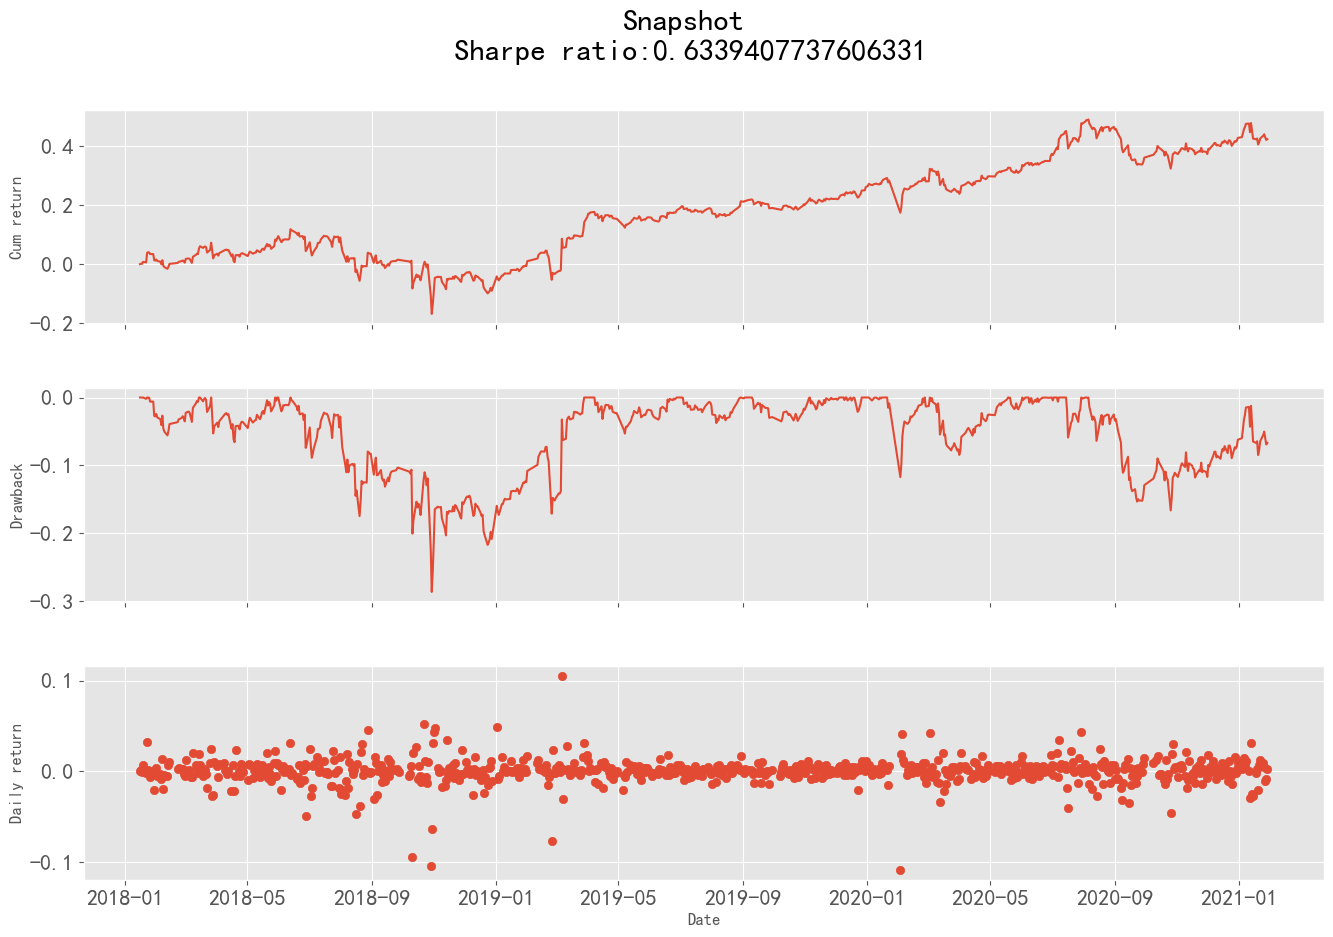

In [36]:
core.plot_rt()

In [37]:
a=pd.DataFrame({'date':core.balance.index,'return':core.drt})
a[a.date>'2018-10-20'].head(20)

,date,return
2018-10-22,2018-10-22,0.051632
2018-10-23,2018-10-23,0.011337
2018-10-24,2018-10-24,-0.006605
2018-10-25,2018-10-25,-0.012535
2018-10-26,2018-10-26,0.010029
2018-10-29,2018-10-29,-0.104005
2018-10-30,2018-10-30,-0.063143
2018-10-31,2018-10-31,0.031097
2018-11-01,2018-11-01,0.042845
2018-11-02,2018-11-02,0.047791


In [38]:
core.value.sort_values()

2018-10-30     86993.0
2018-10-31     89785.0
2018-10-29     92486.0
2018-12-24     93705.0
2018-11-01     93804.0
                ...   
2021-01-11    172848.0
2021-01-13    173296.0
2020-08-05    173481.0
2020-08-04    173587.0
2020-08-06    173967.0
Length: 740, dtype: float64

# Some function

In [39]:
core.date_profit.sort_values()

2018-08-09   -6830.0
2020-09-18   -5656.0
2021-01-18   -5260.0
2021-01-19   -4383.0
2018-11-02   -4307.0
               ...  
2018-08-28    4771.0
2020-07-08    4871.0
2020-03-03    4983.0
2019-03-29    5408.0
2020-07-30    7143.0
Length: 740, dtype: float64

In [40]:
core.strategy[1].date_balance('2019-09-09')

000568      8776.0
000596     11574.0
600763      9720.0
600809      5194.0
601799      6860.0
cash      109770.0
Name: 2019-09-09 00:00:00, dtype: float64

In [41]:
core.strategy[1].position

{'600809': [255.91, 100, 25591.0],
 '300347': [166.41, 100, 16641.0],
 '000661': [460.4, 100, 46040.0],
 '000858': [284.4, 100, 28439.999999999996]}

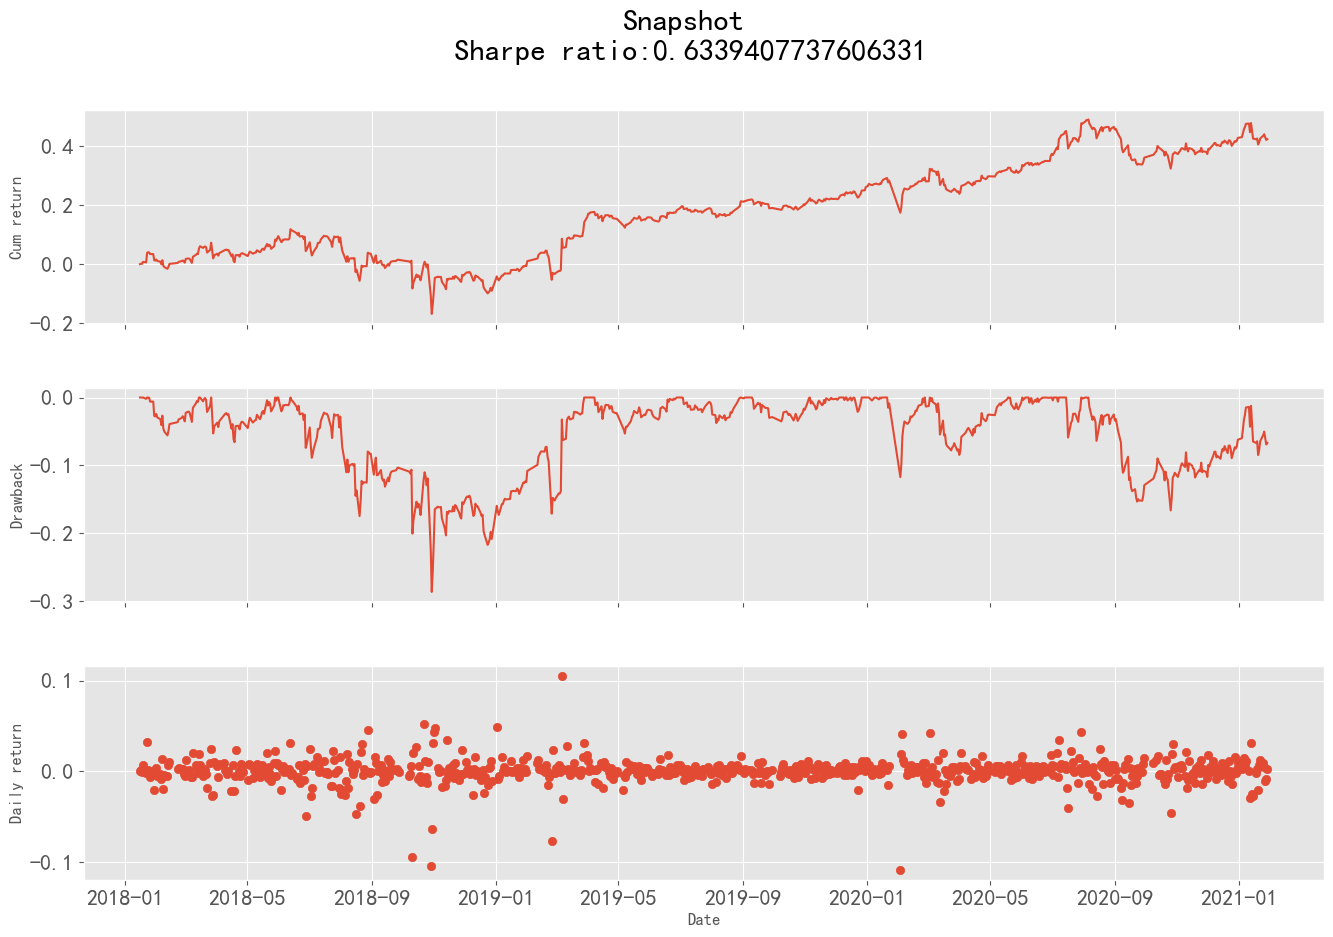

In [42]:
core.plot_rt()

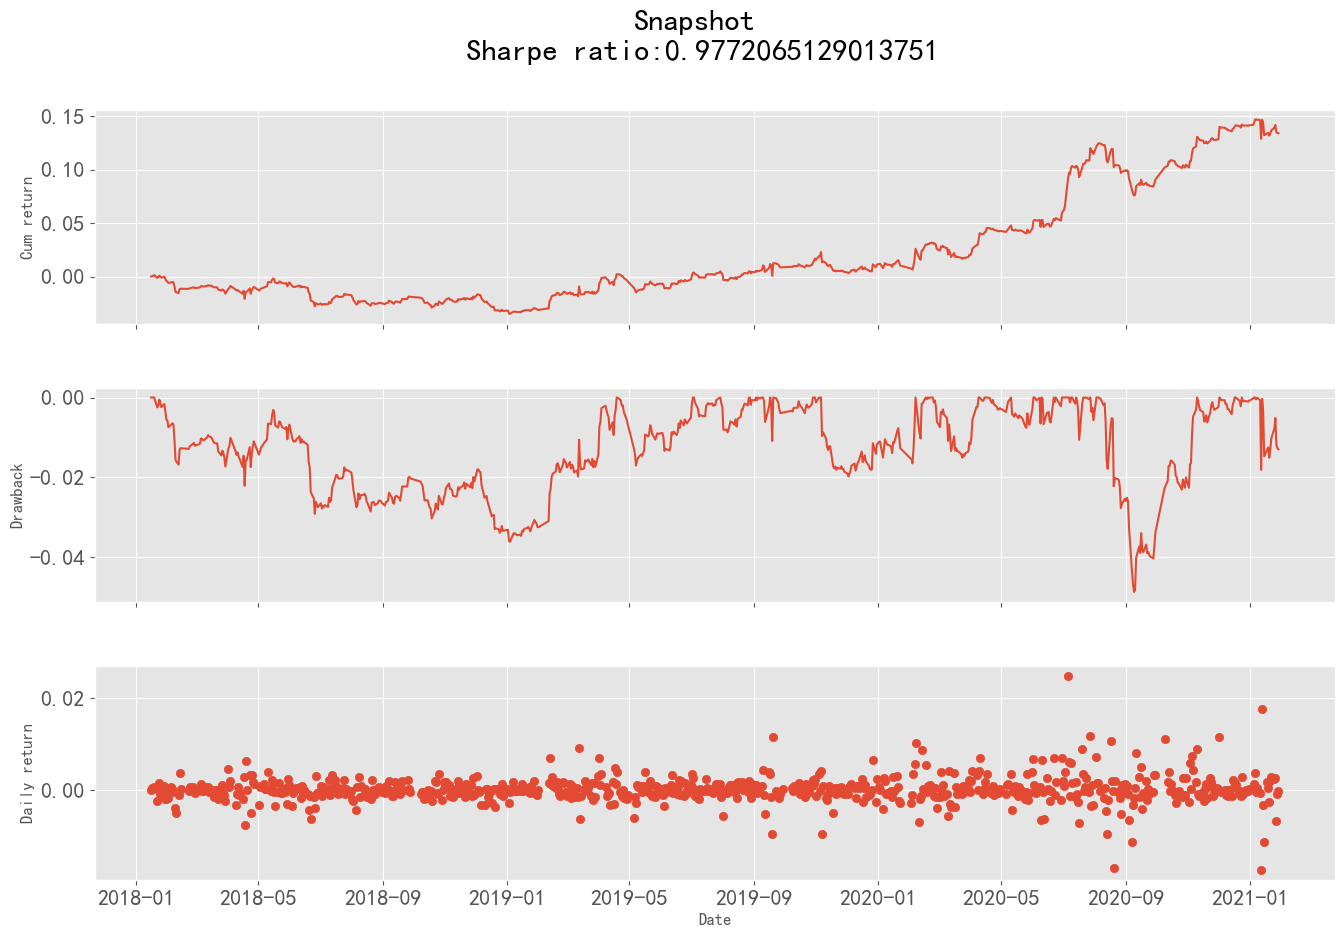

In [43]:
core.strategy[0].plot_rt()

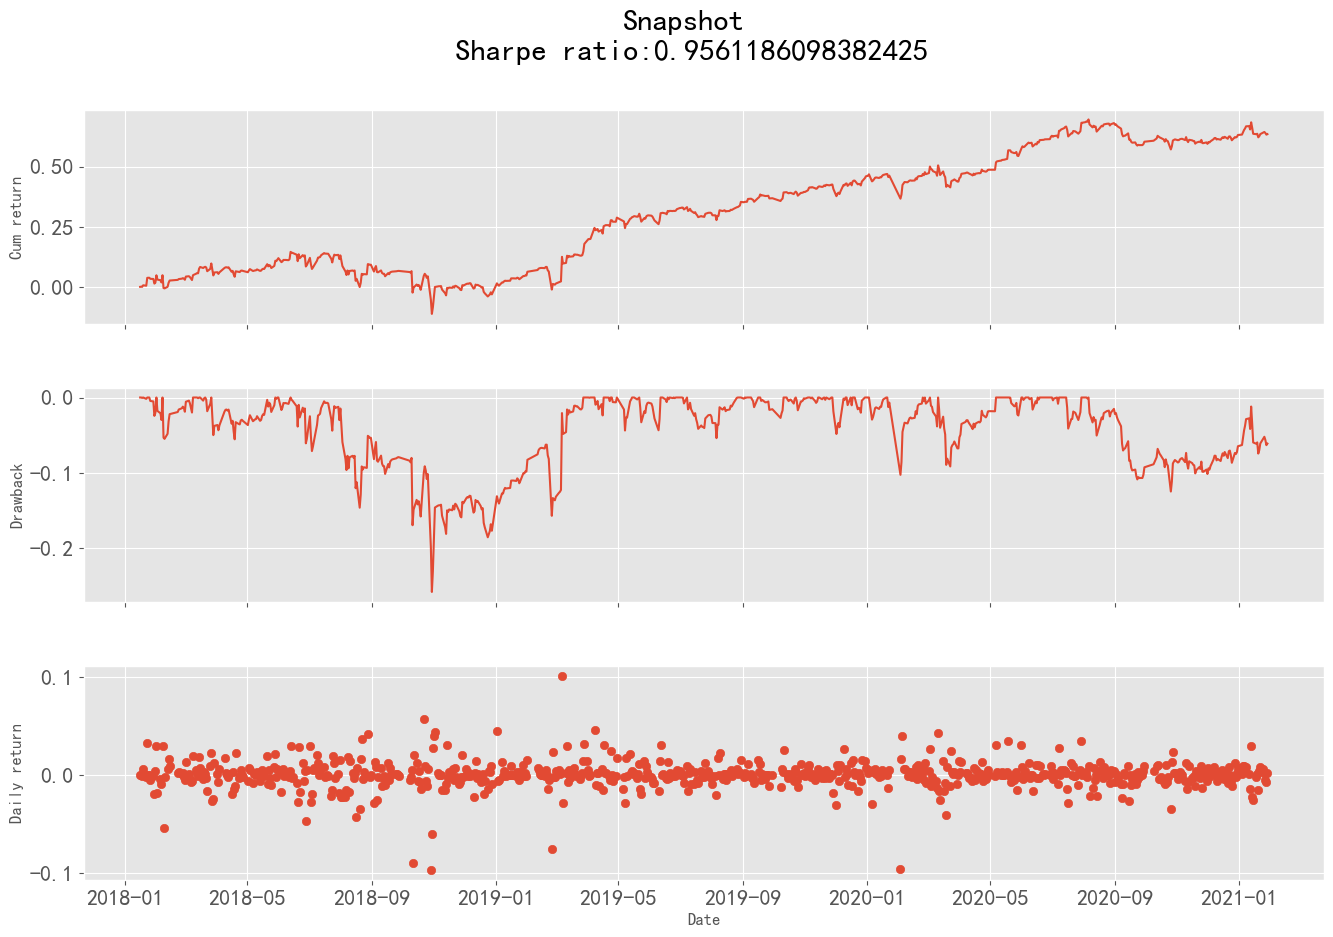

In [44]:
core.strategy[1].plot_rt()